In [7]:
# STEP 1: ENVIRONMENT SETUP

import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

!pip install librosa tensorflow matplotlib seaborn scikit-learn

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import librosa
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Environment setup complete!")


GPU Available: []
  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
Environment setup complete!


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\arnav\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\tensorflow\\compiler\\mlir\\lite\\python\\_pywrap_converter_api.pyd'
Consider using the `--user` option or check the permissions.



In [8]:

# Local dataset directory (auto-create if missing)
DATASET_PATH = os.path.join(os.getcwd(), "data", "mini_speech_commands")
data_dir = pathlib.Path(DATASET_PATH)

# Download if not present
if not data_dir.exists():
    zip_path = tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.',  # Current directory
        cache_subdir='data'
    )
    print("✅ Dataset downloaded and extracted!")

else:
    print("✅ Dataset already exists!")

# List available commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('\nAvailable Commands:', commands)

# Show file counts
for command in commands:
    command_dir = data_dir / command
    if command_dir.is_dir():
        num_files = len(list(command_dir.glob('*.wav')))
        print(f'{command}: {num_files} files')


✅ Dataset already exists!

Available Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
down: 1000 files
go: 1000 files
left: 1000 files
no: 1000 files
right: 1000 files
stop: 1000 files
up: 1000 files
yes: 1000 files


In [9]:
# STEP 3: DATA PREPROCESSING AND FEATURE EXTRACTION

def extract_mfcc_features(file_path, n_mfcc=40, max_len=98):
    try:
        audio, sr = librosa.load(file_path, sr=16000, duration=1.0)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=160, n_fft=512)
        if mfccs.shape[1] < max_len:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]
        return mfccs.T
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def prepare_dataset(data_dir, test_size=0.2, validation_size=0.1):
    features, labels, file_paths = [], [], []
    commands = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    print(f"Processing commands: {commands}")
    for label, command in enumerate(commands):
        command_dir = os.path.join(data_dir, command)
        audio_files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]
        print(f"Processing {command}: {len(audio_files)} files")
        for audio_file in audio_files[:500]:
            file_path = os.path.join(command_dir, audio_file)
            mfcc_features = extract_mfcc_features(file_path)
            if mfcc_features is not None:
                features.append(mfcc_features)
                labels.append(label)
                file_paths.append(file_path)
    features = np.array(features)
    labels = np.array(labels)
    print(f"Dataset shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    X_temp, X_test, y_temp, y_test = train_test_split(features, labels, test_size=test_size, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=validation_size/(1-test_size), random_state=42, stratify=y_temp)
    return (X_train, X_val, X_test, y_train, y_val, y_test), commands

print("Starting data preprocessing...")
(X_train, X_val, X_test, y_train, y_val, y_test), class_names = prepare_dataset(data_dir)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class names: {class_names}")


Starting data preprocessing...
Processing commands: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
Processing down: 1000 files
Processing go: 1000 files
Processing left: 1000 files
Processing no: 1000 files
Processing right: 1000 files
Processing stop: 1000 files
Processing up: 1000 files
Processing yes: 1000 files
Dataset shape: (4000, 98, 40)
Labels shape: (4000,)
Training set: (2800, 98, 40)
Validation set: (400, 98, 40)
Test set: (800, 98, 40)
Class names: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


In [10]:
# STEP 4: MODEL ARCHITECTURE DESIGN

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Reshape((*input_shape, 1), input_shape=input_shape),
        layers.Conv2D(64, (20, 8), strides=(1, 3), activation='relu', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25, name='dropout1'),
        layers.Conv2D(128, (10, 4), strides=(1, 1), activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25, name='dropout2'),
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout3'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    return model

input_shape = (98, 40)
num_classes = len(class_names)

cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.summary()
print("CNN model architecture created.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 98, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 79, 11, 64)     │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 39, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 39, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 30, 2, 128)     │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 15, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 15, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 585,032 (2.23 MB)

 Trainable params: 585,032 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture created.


In [11]:
# STEP 5: MODEL TRAINING

def train_model(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=64):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
    ]
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks, verbose=2)
    print("Training complete. Final epoch metrics:")
    print("Train accuracy:", history.history['accuracy'][-1])
    print("Validation accuracy:", history.history['val_accuracy'][-1])
    return history

history = train_model(cnn_model, X_train, y_train, X_val, y_val)


Epoch 1/30


44/44 - 9s - 202ms/step - accuracy: 0.1368 - loss: 3.9496 - val_accuracy: 0.1425 - val_loss: 2.0720 - learning_rate: 0.0010
Epoch 2/30
44/44 - 6s - 130ms/step - accuracy: 0.1389 - loss: 2.0789 - val_accuracy: 0.1125 - val_loss: 2.0786 - learning_rate: 0.0010
Epoch 3/30


44/44 - 6s - 136ms/step - accuracy: 0.1282 - loss: 2.0766 - val_accuracy: 0.1500 - val_loss: 2.0696 - learning_rate: 0.0010
Epoch 4/30


44/44 - 6s - 132ms/step - accuracy: 0.1475 - loss: 2.0674 - val_accuracy: 0.1875 - val_loss: 2.0412 - learning_rate: 0.0010
Epoch 5/30


44/44 - 5s - 122ms/step - accuracy: 0.1621 - loss: 2.0144 - val_accuracy: 0.2575 - val_loss: 1.9299 - learning_rate: 0.0010
Epoch 6/30


44/44 - 5s - 123ms/step - accuracy: 0.2029 - loss: 1.9707 - val_accuracy: 0.2750 - val_loss: 1.8384 - learning_rate: 0.0010
Epoch 7/30


44/44 - 6s - 128ms/step - accuracy: 0.2629 - loss: 1.9072 - val_accuracy: 0.3425 - val_loss: 1.7398 - learning_rate: 0.0010
Epoch 8/30


44/44 - 6s - 133ms/step - accuracy: 0.2857 - loss: 1.8568 - val_accuracy: 0.3750 - val_loss: 1.6700 - learning_rate: 0.0010
Epoch 9/30


44/44 - 6s - 133ms/step - accuracy: 0.3146 - loss: 1.7507 - val_accuracy: 0.3950 - val_loss: 1.5161 - learning_rate: 0.0010
Epoch 10/30


44/44 - 6s - 126ms/step - accuracy: 0.3879 - loss: 1.5926 - val_accuracy: 0.4975 - val_loss: 1.3895 - learning_rate: 0.0010
Epoch 11/30


44/44 - 5s - 121ms/step - accuracy: 0.4339 - loss: 1.5034 - val_accuracy: 0.5425 - val_loss: 1.2159 - learning_rate: 0.0010
Epoch 12/30


44/44 - 5s - 121ms/step - accuracy: 0.4714 - loss: 1.3945 - val_accuracy: 0.6175 - val_loss: 1.0468 - learning_rate: 0.0010
Epoch 13/30


44/44 - 6s - 127ms/step - accuracy: 0.5611 - loss: 1.1813 - val_accuracy: 0.6525 - val_loss: 0.9289 - learning_rate: 0.0010
Epoch 14/30


44/44 - 6s - 132ms/step - accuracy: 0.6121 - loss: 1.0280 - val_accuracy: 0.6625 - val_loss: 0.8585 - learning_rate: 0.0010
Epoch 15/30


44/44 - 6s - 132ms/step - accuracy: 0.6321 - loss: 1.0182 - val_accuracy: 0.7450 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 16/30
44/44 - 5s - 117ms/step - accuracy: 0.6668 - loss: 0.8934 - val_accuracy: 0.7450 - val_loss: 0.7910 - learning_rate: 0.0010
Epoch 17/30
44/44 - 5s - 121ms/step - accuracy: 0.7171 - loss: 0.7796 - val_accuracy: 0.7400 - val_loss: 0.7477 - learning_rate: 0.0010
Epoch 18/30


44/44 - 6s - 126ms/step - accuracy: 0.7246 - loss: 0.7617 - val_accuracy: 0.7475 - val_loss: 0.7526 - learning_rate: 0.0010
Epoch 19/30


44/44 - 6s - 131ms/step - accuracy: 0.7257 - loss: 0.7620 - val_accuracy: 0.7775 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 20/30
44/44 - 6s - 131ms/step - accuracy: 0.7450 - loss: 0.7254 - val_accuracy: 0.7775 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 21/30


44/44 - 5s - 121ms/step - accuracy: 0.7732 - loss: 0.6263 - val_accuracy: 0.7875 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 22/30


44/44 - 5s - 119ms/step - accuracy: 0.7850 - loss: 0.6277 - val_accuracy: 0.7975 - val_loss: 0.5634 - learning_rate: 0.0010
Epoch 23/30


44/44 - 5s - 120ms/step - accuracy: 0.8043 - loss: 0.5681 - val_accuracy: 0.8150 - val_loss: 0.5804 - learning_rate: 0.0010
Epoch 24/30
44/44 - 5s - 122ms/step - accuracy: 0.8157 - loss: 0.5513 - val_accuracy: 0.8050 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 25/30


44/44 - 6s - 127ms/step - accuracy: 0.8068 - loss: 0.5419 - val_accuracy: 0.8450 - val_loss: 0.4713 - learning_rate: 0.0010
Epoch 26/30
44/44 - 5s - 123ms/step - accuracy: 0.8261 - loss: 0.5225 - val_accuracy: 0.8225 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 27/30
44/44 - 5s - 117ms/step - accuracy: 0.8275 - loss: 0.4924 - val_accuracy: 0.8050 - val_loss: 0.5857 - learning_rate: 0.0010
Epoch 28/30
44/44 - 6s - 130ms/step - accuracy: 0.8282 - loss: 0.4904 - val_accuracy: 0.8375 - val_loss: 0.5465 - learning_rate: 0.0010
Epoch 29/30
44/44 - 6s - 132ms/step - accuracy: 0.8329 - loss: 0.4970 - val_accuracy: 0.8350 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 30/30
44/44 - 5s - 123ms/step - accuracy: 0.8346 - loss: 0.4940 - val_accuracy: 0.8325 - val_loss: 0.5551 - learning_rate: 0.0010
Training complete. Final epoch metrics:
Train accuracy: 0.8346428275108337
Validation accuracy: 0.8324999809265137


Evaluating the model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Test Accuracy: 0.84375
Classification Report:
              precision    recall  f1-score   support

        down       0.86      0.81      0.84       100
          go       0.79      0.69      0.74       100
        left       0.84      0.86      0.85       100
          no       0.75      0.79      0.77       100
       right       0.94      0.93      0.93       100
        stop       0.91      0.88      0.89       100
          up       0.78      0.88      0.83       100
         yes       0.88      0.91      0.90       100

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800



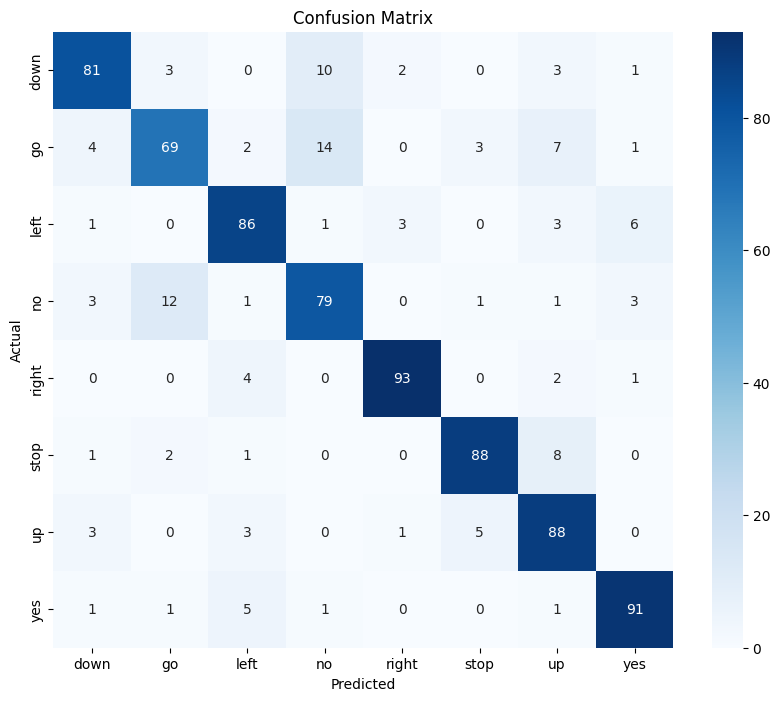

In [12]:
# STEP 6: MODEL EVALUATION

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, class_names):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    test_accuracy = np.mean(predicted_classes == y_test)
    print("Test Accuracy:", test_accuracy)
    print("Classification Report:")
    print(classification_report(y_test, predicted_classes, target_names=class_names))
    cm = confusion_matrix(y_test, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return test_accuracy

print("Evaluating the model...")
test_accuracy = evaluate_model(cnn_model, X_test, y_test, class_names)


In [13]:
# STEP 7: DEPLOYMENT AND SAMPLE INFERENCE

cnn_model.save('speech_command_cnn_model.h5')
print("Model saved as speech_command_cnn_model.h5")

def predict_audio_command(model, audio_file_path, class_names):
    features = extract_mfcc_features(audio_file_path)
    if features is not None:
        features = np.expand_dims(features, axis=0)
        predictions = model.predict(features)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        predicted_class = class_names[predicted_class_idx]
        print(f"Predicted command: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")
        return predicted_class, confidence
    else:
        print("Error: Could not process audio file")
        return None, None

# Test prediction on a sample file
sample_test_file = list((data_dir / class_names[0]).glob('*.wav'))[0]
print(f"Running prediction on: {sample_test_file}")
predict_audio_command(cnn_model, str(sample_test_file), class_names)


Model saved as speech_command_cnn_model.h5
Running prediction on: c:\Users\arnav\OneDrive\Desktop\data\mini_speech_commands\down\004ae714_nohash_0.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted command: down
Confidence: 0.5360


('down', 0.53603756)

In [15]:
# def predict_audio_command(model, audio_file_path, class_names):
#     '''Predict speech command from audio file'''
#     features = extract_mfcc_features(audio_file_path)

#     if features is not None:
#         features = np.expand_dims(features, axis=0)
#         predictions = model.predict(features)
#         predicted_class_idx = np.argmax(predictions[0])
#         confidence = predictions[0][predicted_class_idx]
#         predicted_class = class_names[predicted_class_idx]

#         print(f"Predicted command: {predicted_class}")
#         print(f"Confidence: {confidence:.4f}")

#         return predicted_class, confidence

#     return None, None

# STEP 7: MODEL DEPLOYMENT AND INFERENCE

# Save the trained model
cnn_model.save('speech_command_cnn_model.h5')
print("✓ Model saved as 'speech_command_cnn_model.h5'\n")

def predict_audio_command(model, audio_file_path, class_names):
    """
    Predict speech command from an audio file
    
    Args:
        model: Trained Keras model
        audio_file_path (str): Path to the audio file
        class_names (list): List of command class names
        
    Returns:
        tuple: (predicted_class, confidence) or (None, None) if error
    """
    # Extract MFCC features from audio file
    features = extract_mfcc_features(audio_file_path)
    
    if features is None:
        print("❌ Error: Could not process audio file")
        return None, None
    
    # Reshape for model input (add batch dimension)
    features = np.expand_dims(features, axis=0)
    
    # Make prediction
    predictions = model.predict(features, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    # Display results
    print(f"🎯 Predicted command: {predicted_class}")
    print(f"📊 Confidence: {confidence:.2%}")
    
    return predicted_class, confidence

# ========================================
# TEST PREDICTIONS ON SAMPLE FILES
# ========================================

print("="*60)
print("TESTING PREDICTIONS ON SAMPLE FILES")
print("="*60)

# Test 1: Single sample from first class
print("\n--- Test 1: Single Sample ---")
sample_test_file = list((data_dir / class_names[0]).glob('*.wav'))[0]
print(f"File: {sample_test_file.name}")
predict_audio_command(cnn_model, str(sample_test_file), class_names)

# Test 2: Random sample from each class
print("\n--- Test 2: One Sample Per Class ---")
np.random.seed(42)
for class_name in class_names:
    audio_files = list((data_dir / class_name).glob('*.wav'))
    if audio_files:
        sample_file = np.random.choice(audio_files)
        print(f"\n📁 Testing '{class_name}':")
        print(f"   File: {sample_file.name}")
        predict_audio_command(cnn_model, str(sample_file), class_names)

# Test 3: Prediction on multiple samples with summary
print("\n" + "="*60)
print("BATCH PREDICTION SUMMARY")
print("="*60)

correct_predictions = 0
total_predictions = 0

for class_name in class_names:
    audio_files = list((data_dir / class_name).glob('*.wav'))
    # Test 5 random samples per class
    test_samples = np.random.choice(audio_files, min(5, len(audio_files)), replace=False)
    
    for sample_file in test_samples:
        predicted, conf = predict_audio_command(cnn_model, str(sample_file), class_names)
        if predicted == class_name:
            correct_predictions += 1
        total_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100
print(f"\n✅ Batch Test Accuracy: {correct_predictions}/{total_predictions} ({accuracy:.2f}%)")

print("\n" + "="*60)
print("DEPLOYMENT READY!")
print("="*60)
print("To use the model in production:")
print("1. Load model: model = tf.keras.models.load_model('speech_command_cnn_model.h5')")
print("2. Call: predict_audio_command(model, 'path/to/audio.wav', class_names)")


✓ Model saved as 'speech_command_cnn_model.h5'

TESTING PREDICTIONS ON SAMPLE FILES

--- Test 1: Single Sample ---
File: 004ae714_nohash_0.wav
🎯 Predicted command: down
📊 Confidence: 53.60%

--- Test 2: One Sample Per Class ---

📁 Testing 'down':
   File: 1d919a90_nohash_0.wav
🎯 Predicted command: down
📊 Confidence: 86.83%

📁 Testing 'go':
   File: 721f767c_nohash_0.wav
🎯 Predicted command: go
📊 Confidence: 84.23%

📁 Testing 'left':
   File: dea820ce_nohash_2.wav
🎯 Predicted command: left
📊 Confidence: 68.42%

📁 Testing 'no':
   File: 46a153d8_nohash_4.wav
🎯 Predicted command: no
📊 Confidence: 88.79%

📁 Testing 'right':
   File: 21832144_nohash_3.wav
🎯 Predicted command: right
📊 Confidence: 99.55%

📁 Testing 'stop':
   File: 1816b768_nohash_1.wav
🎯 Predicted command: stop
📊 Confidence: 99.99%

📁 Testing 'up':
   File: ba59cab3_nohash_0.wav
🎯 Predicted command: up
📊 Confidence: 78.90%

📁 Testing 'yes':
   File: 03cf93b1_nohash_0.wav
🎯 Predicted command: yes
📊 Confidence: 99.96%

BATCH P

In [16]:
# STEP 7: MODEL DEPLOYMENT AND INFERENCE

# Save the trained model
cnn_model.save('speech_command_cnn_model.keras')  # Use new Keras format
print("✓ Model saved as 'speech_command_cnn_model.keras'\n")

def predict_audio_command(model, audio_file_path, class_names):
    """
    Predict speech command from an audio file
    
    Args:
        model: Trained Keras model
        audio_file_path (str): Path to the audio file
        class_names (list): List of command class names
        
    Returns:
        tuple: (predicted_class, confidence) or (None, None) if error
    """
    features = extract_mfcc_features(audio_file_path)
    
    if features is None:
        print("❌ Error: Could not process audio file")
        return None, None
    
    features = np.expand_dims(features, axis=0)
    predictions = model.predict(features, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    return predicted_class, confidence

# ========================================
# TEST PREDICTIONS
# ========================================

print("="*60)
print("TESTING PREDICTIONS ON SAMPLE FILES")
print("="*60)

# Test 1: Single sample
print("\n--- Test 1: Single Sample ---")
sample_test_file = list((data_dir / class_names[0]).glob('*.wav'))[0]
print(f"File: {sample_test_file.name}")
pred, conf = predict_audio_command(cnn_model, str(sample_test_file), class_names)
print(f"🎯 Predicted: {pred} | Confidence: {conf:.2%}")

# Test 2: One sample per class (COMPACT OUTPUT)
print("\n--- Test 2: One Sample Per Class ---")
np.random.seed(42)
results = []
for class_name in class_names:
    audio_files = list((data_dir / class_name).glob('*.wav'))
    if audio_files:
        sample_file = np.random.choice(audio_files)
        pred, conf = predict_audio_command(cnn_model, str(sample_file), class_names)
        status = "✓" if pred == class_name else "✗"
        results.append((class_name, pred, conf, status))
        print(f"{status} True: {class_name:6} | Predicted: {pred:6} | Confidence: {conf:.2%}")

# Test 3: Batch accuracy
print("\n--- Test 3: Batch Prediction Summary ---")
correct = 0
total = 0
np.random.seed(42)

for class_name in class_names:
    audio_files = list((data_dir / class_name).glob('*.wav'))
    test_samples = np.random.choice(audio_files, min(5, len(audio_files)), replace=False)
    
    class_correct = 0
    for sample_file in test_samples:
        predicted, conf = predict_audio_command(cnn_model, str(sample_file), class_names)
        if predicted == class_name:
            correct += 1
            class_correct += 1
        total += 1
    
    class_acc = (class_correct / len(test_samples)) * 100
    print(f"  {class_name:6}: {class_correct}/{len(test_samples)} correct ({class_acc:.0f}%)")

accuracy = (correct / total) * 100
print(f"\n✅ Overall Batch Accuracy: {correct}/{total} ({accuracy:.2f}%)")

# Deployment instructions
print("\n" + "="*60)
print("DEPLOYMENT READY!")
print("="*60)
print("To use the model in production:")
print("  1. Load: model = tf.keras.models.load_model('speech_command_cnn_model.keras')")
print("  2. Use:  predict_audio_command(model, 'audio.wav', class_names)")
print("="*60)

✓ Model saved as 'speech_command_cnn_model.keras'

TESTING PREDICTIONS ON SAMPLE FILES

--- Test 1: Single Sample ---
File: 004ae714_nohash_0.wav
🎯 Predicted: down | Confidence: 53.60%

--- Test 2: One Sample Per Class ---
✓ True: down   | Predicted: down   | Confidence: 86.83%
✓ True: go     | Predicted: go     | Confidence: 84.23%
✓ True: left   | Predicted: left   | Confidence: 68.42%
✓ True: no     | Predicted: no     | Confidence: 88.79%
✓ True: right  | Predicted: right  | Confidence: 99.55%
✓ True: stop   | Predicted: stop   | Confidence: 99.99%
✓ True: up     | Predicted: up     | Confidence: 78.90%
✓ True: yes    | Predicted: yes    | Confidence: 99.96%

--- Test 3: Batch Prediction Summary ---
  down  : 4/5 correct (80%)
  go    : 4/5 correct (80%)
  left  : 5/5 correct (100%)
  no    : 4/5 correct (80%)
  right : 5/5 correct (100%)
  stop  : 4/5 correct (80%)
  up    : 4/5 correct (80%)
  yes   : 4/5 correct (80%)

✅ Overall Batch Accuracy: 34/40 (85.00%)

DEPLOYMENT READY!


In [ ]:
project_folder/
│
├── speech_command_cnn_model.keras    # 🎯 The trained model
├── predict_audio_command.py          # 🔧 Inference function
├── extract_mfcc_features.py          # 🎵 Audio preprocessing
├── requirements.txt                  # 📦 Dependencies
├── README.md                         # 📖 Documentation
├── demo.py                           # 🎮 Example usage
├── test_samples/                     # 🎤 Sample audio files
│   ├── yes.wav
│   ├── no.wav
│   └── ...
└── model_performance/                # 📊 Results
    ├── confusion_matrix.png
    ├── accuracy_plot.png
    └── classification_report.txt